# steam游戏分析

## 1 数据处理（兰家豪、祝昳雯）

### 1.1 数据来源
steam游戏榜/样本容量：561个

### 1.2 数据爬取


In [ ]:
#爬取游戏列表及网址
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

headers = {'User-Agent': 'Mozilla/5.0'}
#替换你自己的headers
n =26
#n代表爬取到多少页
path = '11.xlsx'
#修改你的保存位置

def getgamelist(n):
    linklist=[]
    IDlist = []
    for pagenum in range(0,n):
        r = requests.get('https://store.steampowered.com/search/?ignore_preferences=1&category1=998&os=win&filter=globaltopsellers&page=%d'%pagenum,headers=headers)
        soup = BeautifulSoup(r.text, 'lxml')
        soups= soup.find_all(href=re.compile(r"https://store.steampowered.com/app/"),class_="search_result_row ds_collapse_flag")
        for i in soups:
            i = i.attrs
            i = i['href']
            link = re.search('https://store.steampowered.com/app/(\d*?)/',i).group()
            ID = re.search('https://store.steampowered.com/app/(\d*?)/(.*?)/', i).group(1)
            linklist.append(link)
            IDlist.append(ID)
        print('已完成'+str(pagenum)+'页,目前共'+str(len(linklist)))
    return linklist,IDlist

def getdf(n):#转df
    linklist,IDlist = getgamelist(n)
    df = pd.DataFrame(list(zip(linklist,IDlist)),
               columns =['Link', 'ID'])
    return df
if __name__ == "__main__":
    df = getdf(n)#n代表爬取到多少页
    df.to_excel(path)#储存

In [ ]:
#按游戏列表爬取各游戏信息
def gamename(soup):   #游戏名字
    try:
        a = soup.find(class_="apphub_AppName")
        k = str(a.string)
    except:
        a = soup.find(class_="apphub_AppName")
        k = str(a.text)
    return k

def gameprice(soup):#价格
    try:
        a = soup.findAll(class_="discount_original_price")
        for i in a:
            if re.search('¥|free|免费', str(i),re.IGNORECASE):
                a = i
        k = str(a.string).replace('	', '').replace('\n', '').replace('\r', '').replace(' ', '')
    except:
        a = soup.findAll(class_="game_purchase_price price")
        for i in a:
            if re.search('¥|free|免费', str(i),re.IGNORECASE):
                a = i
        k = str(a.string).replace('	', '').replace('\n', '').replace('\r', '').replace(' ', '')
    return k

def taglist(soup):#标签列表
    list1=[]
    a = soup.find_all(class_="app_tag")
    for i in a:
        k = str(i.string).replace('	', '').replace('\n', '').replace('\r', '')
        if k == '+':
            pass
        else:
            list1.append(k)
    list1 = str('\n'.join(list1))
    return list1

def description(soup):  #游戏描述
    a = soup.find(class_="game_description_snippet")
    k = str(a.string).replace('	', '').replace('\n', '').replace('\r', '')
    return k

def reviewsummary(soup):   #总体评价
    a = soup.find(class_="summary column")
    try:
        k = str(a.span.string)
    except:
        k=str(a.text)
    return k

def getdate(soup):   #发行日期
    a = soup.find(class_="date")
    k = str(a.string)
    return k

def userreviewsrate(soup):#总体数量好评率
    a = soup.find(class_="user_reviews_summary_row")
    k = str((a.attrs)['data-tooltip-html'])
    return k

def developer(soup):   #开发商
    a = soup.find(id="developers_list")
    k = str(a.a.string)
    return k

def getreviews(ID):#获取评论
    r1 = requests.get(
        'https://store.steampowered.com/appreviews/%s?cursor=*&day_range=30&start_date=-1&end_date=-1&date_range_type=all&filter=summary&language=schinese&l=schinese&review_type=positive&purchase_type=all&playtime_filter_min=0&playtime_filter_max=0&filter_offtopic_activity=1'%str(ID),headers=headers,timeout=10)
    soup = BeautifulSoup(r1.json()['html'], 'lxml')
    a = soup.findAll(class_="content")
    list1 = []
    for i in a:
        list1.append(i.text.replace('	', '').replace('\n', '').replace('\r', '').replace(' ', ','))
    k=str('\n'.join(list1))
    return k

def getdetail(x):
    tag, des, reviews, date, rate, dev, review,name,price = ' ', ' ', ' ', ' ', ' ', ' ', ' ',' ',' '
    global count
    try:
        r = requests.get(x['Link'], headers=headers,timeout=10)
    except:
        print('服务器无响应1')
        try:
            r = requests.get(x['Link'], headers=headers,timeout=10)
        except:
            print('服务器无响应2')
            try:
                r = requests.get(x['Link'], headers=headers,timeout=10)
            except:
                print('服务器无响应3')

    try:
        soup = BeautifulSoup(r.text, 'lxml')
        name = gamename(soup)
        tag = taglist(soup)
        des = description(soup)
        reviews = reviewsummary(soup)
        date = getdate(soup)
        rate = userreviewsrate(soup)
        dev = developer(soup)
        review = getreviews(str(x['ID']))
        price = gameprice(soup)
        print('已完成: '+name+str(x['ID'])+'第%d个'%count)
    except:
        print('未完成:  '+str(x['ID'])+'第%d个'%count)
        price = 'error'

    count += 1
    return name,price,tag,des,reviews,date,rate,dev,review


if __name__ == "__main__":
    df1 = pd.read_excel('1.xlsx')
    count = 1
    df1['详细'] = df1.apply(lambda x: getdetail(x), axis=1)
    df1['名字'] = df1.apply(lambda x: x['详细'][0], axis=1)
    df1['价格'] = df1.apply(lambda x: x['详细'][1], axis=1)
    df1['标签'] = df1.apply(lambda x: x['详细'][2], axis=1)
    df1['描述'] = df1.apply(lambda x: x['详细'][3], axis=1)
    df1['近期评价'] = df1.apply(lambda x: x['详细'][4], axis=1)
    df1['发行日期'] = df1.apply(lambda x: x['详细'][5], axis=1)
    df1['近期数量好评率'] = df1.apply(lambda x: x['详细'][6], axis=1)
    df1['开发商'] = df1.apply(lambda x: x['详细'][7], axis=1)
    df1['评论'] = df1.apply(lambda x: x['详细'][8], axis=1)
    
    df1.to_excel('positive.xlsx')
    print('已完成全部')

### 1.3 数据清洗

#### 1.3.1 清理无效数据

In [ ]:
#清理error行并整理价格的格式
import pandas as pd
df1 = pd.read_excel('positive.xlsx')
df2=df1[-df1.价格.isin(['error'])]
df3=df2[-df2.近期数量好评率.isin(['No user reviews'])]
df3['价格']=df3['价格'].str.replace('FreeToPlay','$0')
df3['价格']=df3['价格'].str.replace('reetoPlay','0')
df3['价格']=df3['价格'].str.replace('ree','0')
df3['价格']=df3['价格'].str.replace('layforF0!','0')
jiage=df3['价格']
pricelist=[]
#去掉￥
for jg in jiage:
    jg1=jg[1:]
    pricelist.append(jg1)
#df3['评论']

#### 1.3.2 转换数据格式

In [ ]:
#去掉价格千分位并转换int格式
import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
pricelist1=[]
for i in range(len(pricelist)):
    a=locale.atoi(pricelist[i])
    pricelist1.append(a)
pricelist1=[int(x) for x in pricelist1]

In [ ]:
#删除游戏评论列（减少内存占用）
df4=df3.reset_index(drop=True)
df5=df4.drop(columns=['评论'])
#df5.to_excel('negative.xls')😘
#转换日期格式+提取年数据
df5['发行日期'] = pd.to_datetime(df5['发行日期'] )
df5['年'] = df5['发行日期'].dt.year
#提取近期数量好评率里的评价人数和好评率
num_raw=[]
rate=[]
for i in range(len(df5['近期数量好评率'])):
    rating=df5['近期数量好评率'][i]
    ratinglist=rating.split()
    rate_per=ratinglist[0]
    month_num=ratinglist[3]
    num_raw.append(month_num)
    rate.append(rate_per)
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
num=[]
for i in range(len(num_raw)):
    a=locale.atoi(num_raw[i])
    num.append(a)
num_final=[int(x) for x in num]
df5['近期评价人数']=num
df5['近期好评率']=rate
df5.to_excel('negative.xls')

In [ ]:
#单独提取好评和差评
cm=df4['评论']
cmlist=[]
for i in range(0,len(cm)):
    b=cm[i]
    cmlist.append(b)
ng_cm=pd.DataFrame(cmlist)
#ng_cm.to_excel('pt_cm.xls')
#ng_cm.to_excel('ng_cm.xls')
cmlist

In [ ]:
#提取游戏标签，根据标签出现次数统计好评率
import pandas as pd
df=pd.read_excel('basic_info(1).xlsx')
a=df['标签']
tg_cm_list=[]
for i in range(len(a)):
    b=a[i]
    c=b.split('\n')
    haopinglv=df['近期好评率']
    d=haopinglv[i]
    list=[d for x in range(len(c))]
    zipped=zip(c,list)#dic=dict(map(lambda x,y:[x,y],c,list))
    df_zipped=pd.DataFrame(zipped)
    df_zipped.columns=['tag','rate']
    tg_cm_list.append(df_zipped)
tg_cm_list[560]
#data=pd.DataFrame(zipped)
#生成标签和好评率的df
final=tg_cm_list[0]
for x in range(len(tg_cm_list)):
    final=pd.merge(final,tg_cm_list[x],on='tag',how='outer')
final

In [ ]:
#提取游戏标签，根据标签出现次数统计好评人数
a=df['标签']
tg_num_list=[]
for i in range(len(a)):
    b=a[i]
    c=b.split('\n')
    df['好评人数']=df['近期好评率']*df['近期评价人数']
    haopingrenshu=df['好评人数']
    d=haopingrenshu[i]
    list=[d for x in range(len(c))]
    zipped=zip(c,list)#dic=dict(map(lambda x,y:[x,y],c,list))
    df_zipped=pd.DataFrame(zipped)
    df_zipped.columns=['tag','num']
    tg_num_list.append(df_zipped)
tg_num_list[1]
#生成标签和好评人数的df并储存
from functools import reduce
df_final = reduce(lambda left, right: pd.merge(left, right, on='tag',how='outer'), tg_num_list)
df_final.to_excel('标签好评人数.xlsx')

In [ ]:
#查看tag是否重复
print(final.index.is_unique)

In [ ]:
#统计各标签好评率的平均值
final['ave']=final.mean(1)
tg_cm=final[['tag','ave']]
tg_cm.to_excel('标签平均好评率.xls')

#### 1.3.3 根据标签汇总评论

In [ ]:
#根据标签提取评价并汇总
import pandas as pd
df=pd.read_excel('positive.xlsx')
a=df['标签']
tg_cm_list=[]
for i in range(len(a)):
    b=a[i]
    c=b.split('\n')
    haopinglv=df['评论']
    d=haopinglv[i]
    list=[d for x in range(len(c))]
    zipped=zip(c,list)#dic=dict(map(lambda x,y:[x,y],c,list))
    df_zipped=pd.DataFrame(zipped)
    df_zipped.columns=['tag','rate']
    tg_cm_list.append(df_zipped)
#tg_cm_list[560]
#data=pd.DataFrame(zipped)
tg=final['tag']
tg_list=[]
for i in range(0,371):
    tg_single=tg[i]
    tg_list.append(tg_single)
len(tg_list)

#汇总好评
tg_cm_list1=[]
for tag in tg_list:
    tg_cm_list2=[]
    for x in range(len(a)):
        if tag in str(a[x]):
            tg_cm_list2.append(haopinglv[x])
    tg_cm_list1.append(tg_cm_list2)    

#将tag变为行索引
df1=pd.DataFrame(tg_cm_list1)
df1.index=tg_list
df1


df1.to_excel('tag_cm.xlsx')

## 2 数据分析(朱佳露）

### 2.1 市场分析（开发商角度）

In [15]:
import pandas as pd
import numpy as np

In [35]:
#数据可视化、市场分析和相关分析
data1 = pd.read_excel('basic_info.xlsx')
data = data1.iloc[:,4:]
data['近期好评率'].describe()

In [17]:
print(data.shape)
data['开发商'].nunique()

(562, 14)


406

In [18]:
#关于开发商的市场分析
data['近期好评率'] = data['近期好评率']*100
data['销售额'] = data['价格']*data['近期评价人数']
data.sort_values('销售额',ascending = False)
table1 = data.groupby(['开发商'])['近期好评率'].mean().reset_index()
table2 = table1.sort_values('近期好评率',ascending=False)
table2.head(10)

,开发商,近期好评率
133,GB Patch Games,100.0
400,mestiez,99.0
392,Wube Software LTD.,99.0
214,Mega Crit Games,98.0
195,Landfall,98.0
347,Team Reptile,98.0
77,ConcernedApe,98.0
327,Steel Crate Games,98.0
247,Oskar Stålberg,98.0
99,Draw Me A Pixel,98.0


In [19]:
table3 = data.groupby(['开发商'])['开发商'].count().reset_index(name = '开发游戏个数')
table4 = table3.sort_values('开发游戏个数',ascending = False)
table4.head(10)

,开发商,开发游戏个数
380,Valve,13
366,"USERJOY Technology Co.,Ltd.",7
18,Arc System Works,7
371,Ubisoft Montreal,7
62,CREATIVE ASSEMBLY,7
322,"Spike Chunsoft Co., Ltd.",7
180,"KOEI TECMO GAMES CO., LTD.",7
85,CyberConnect2 Co. Ltd.,6
255,Paradox Development Studio,5
58,"CAPCOM Co., Ltd.",5


In [20]:
#销售额计算来源
table5 = data.groupby(['开发商'])['销售额'].sum().reset_index()
table6 = table5.sort_values('销售额',ascending=False)
table6.head(20)

,开发商,销售额
135,Gaijin Entertainment,23661840
58,"CAPCOM Co., Ltd.",21402685
169,Innersloth,19568392
371,Ubisoft Montreal,14807486
211,Maxis,13764560
32,Behaviour Interactive Inc.,10244094
55,Bungie,9778910
300,SCS Software,9544332
176,Jagex,6103768
336,Studio Wildcard,5467594


In [21]:
table7 = pd.merge(table1,table3)
table8 = pd.merge(table6,table7,how = 'left').reset_index()
total_sales = table8['销售额'].sum()
table8 ['市场份额'] = table8['销售额']/total_sales*100
table9 = table8.iloc[0:10,:]
table9

,index,开发商,销售额,近期好评率,开发游戏个数,市场份额
0,0,Gaijin Entertainment,23661840,81.000000,2,10.020913
1,1,"CAPCOM Co., Ltd.",21402685,89.600000,5,9.064149
2,2,Innersloth,19568392,96.000000,2,8.287316
3,3,Ubisoft Montreal,14807486,87.714286,7,6.271047
4,4,Maxis,13764560,89.000000,2,5.829363
5,5,Behaviour Interactive Inc.,10244094,87.000000,2,4.338427
6,6,Bungie,9778910,82.000000,2,4.141419
7,7,SCS Software,9544332,97.000000,3,4.042074
8,8,Jagex,6103768,87.000000,2,2.584978
9,9,Studio Wildcard,5467594,88.000000,2,2.315555


In [22]:
market_share_of_top10 = table9['市场份额'].sum()
print('前十开发商的市场份额为: %.2f%% '%market_share_of_top10 )

前十开发商的市场分额为: 56.90% 


### 2.2 行业分析（游戏角度）

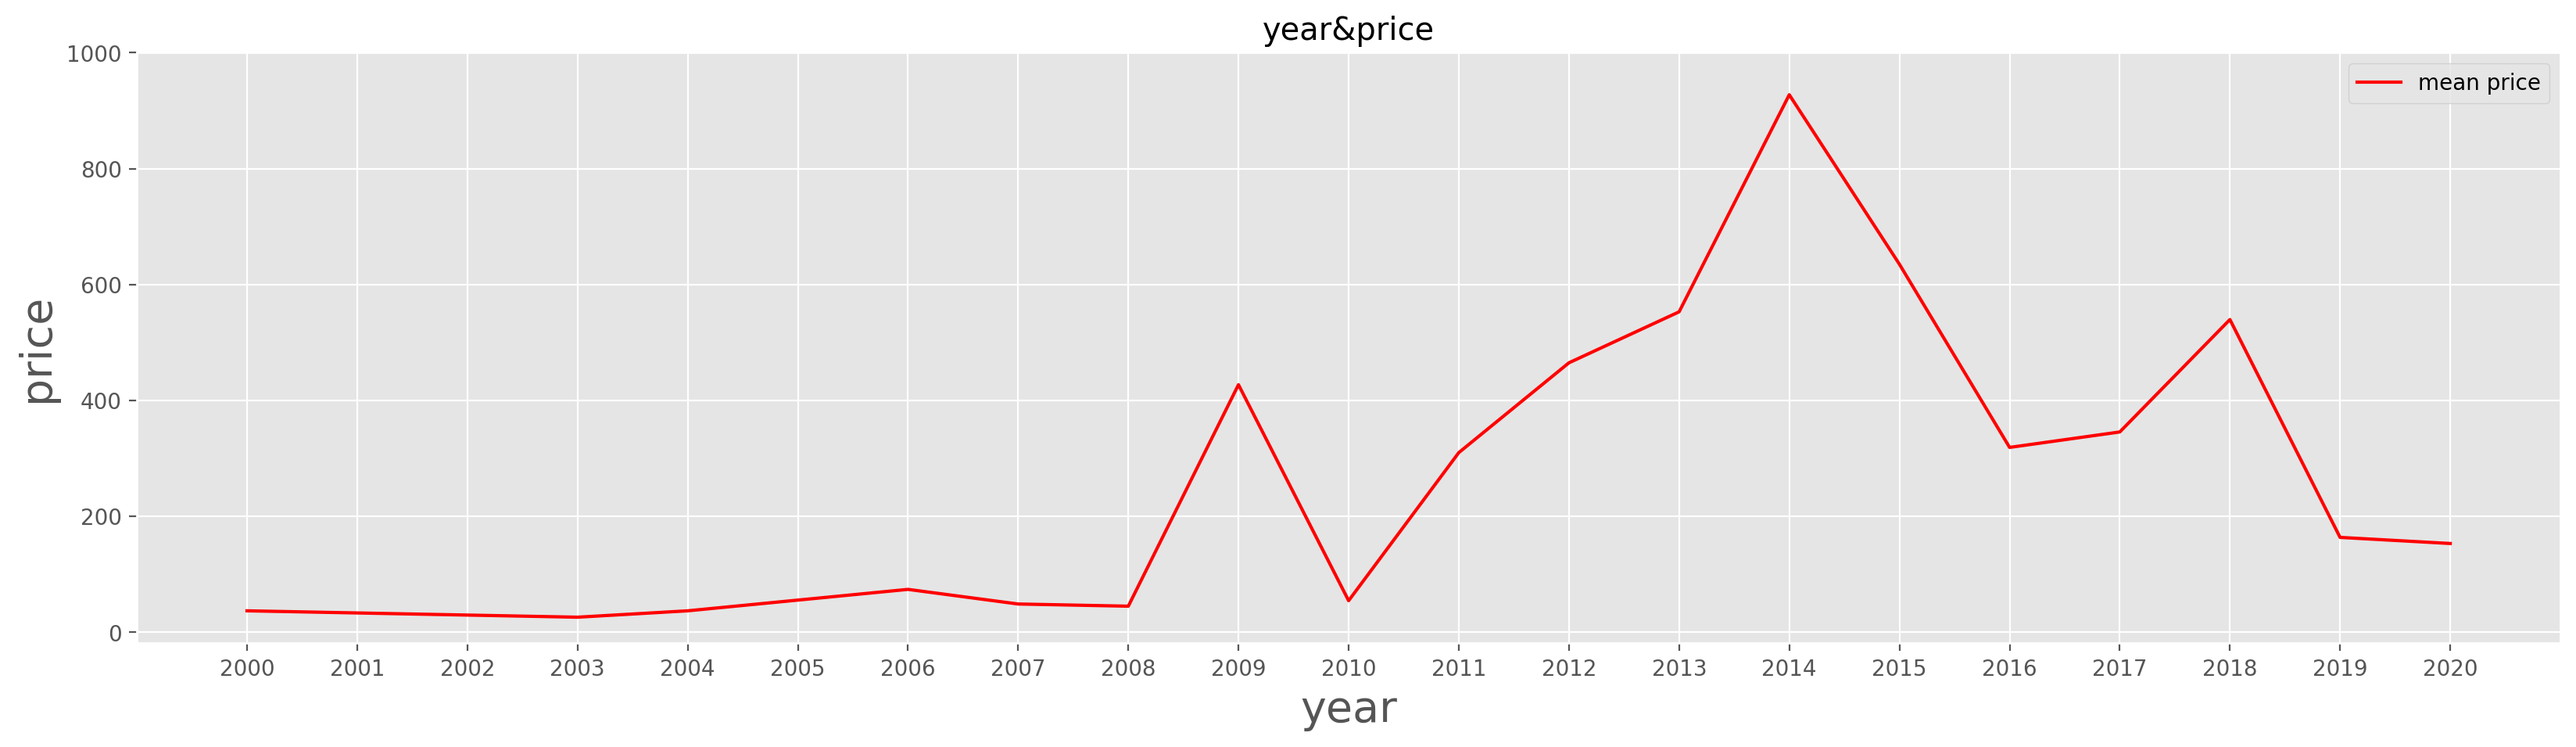

In [8]:
x1= data.groupby('年')['价格'].mean().to_frame().reset_index().sort_values(by='年')#按年分组，求平均价格

plt.figure(figsize=(20, 5),dpi = 200)
plt.plot(x1['年'],x1['价格'], c='r',label='mean price')
plt.xlabel('year',fontsize=20)
plt.ylabel('price',fontsize=20)
plt.legend()
plt.title('year&price')
plt.xticks(range(2000,2021))
plt.yticks(range(0,1200,200))
plt.show()

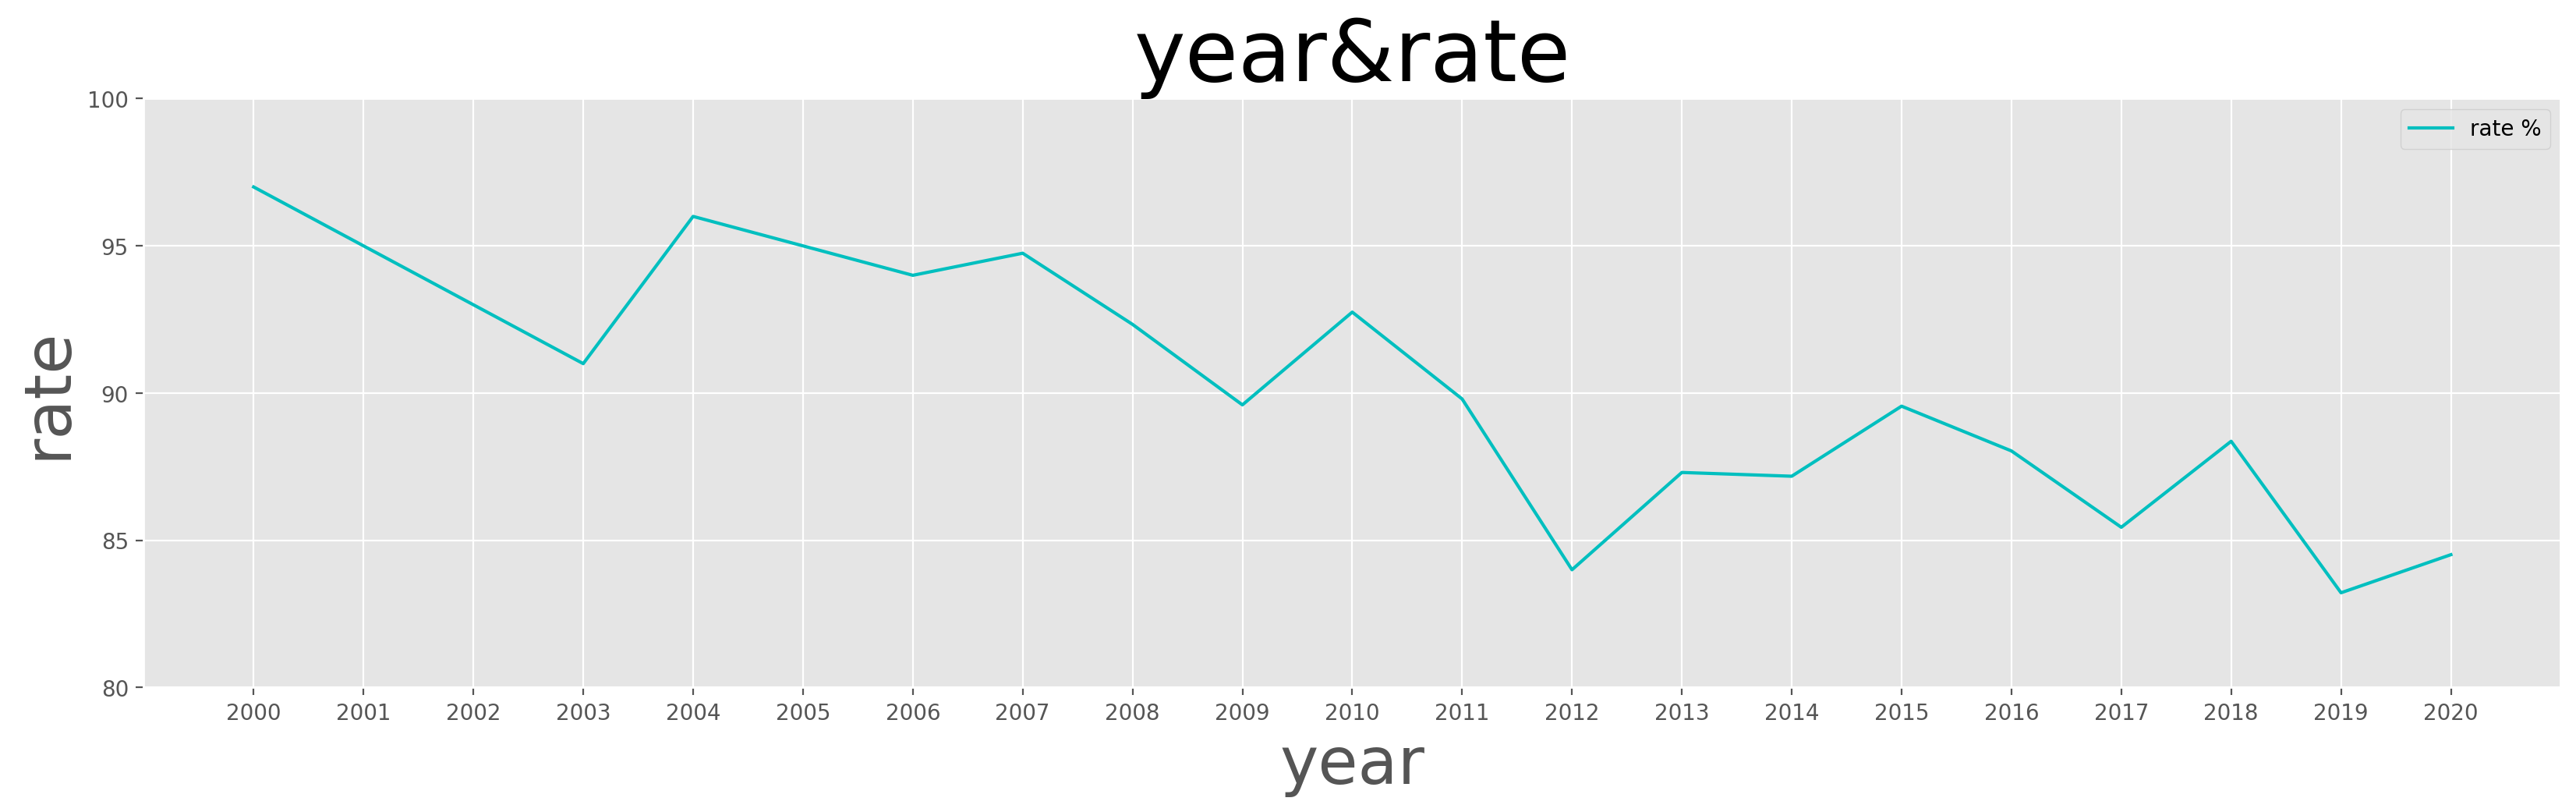

In [9]:
x2 = data.groupby('年')['近期好评率'].mean().to_frame().reset_index().sort_values(by='年')
plt.figure(figsize=(20, 5),dpi = 200)
plt.plot(x2['年'],x2['近期好评率'], c='c',label='rate %')
plt.xlabel('year',fontsize=30)
plt.ylabel('rate',fontsize=30)
plt.legend()
plt.title('year&rate',fontsize=40)
plt.xticks(range(2000,2021))
plt.yticks(range(80,105,5))
plt.show()

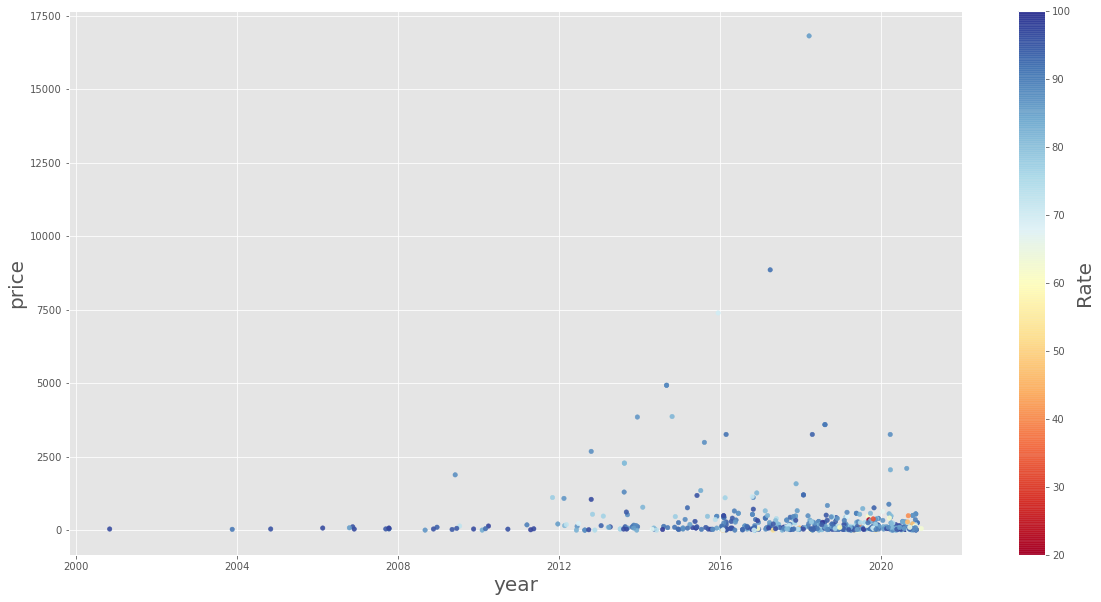

In [31]:
import matplotlib.pyplot as plt 
%matplotlib inline
Y = data['价格'] 
X = data['发行日期']
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.scatter(X,Y,s=20, c=data['近期好评率'], alpha=.9,cmap=plt.get_cmap('RdYlBu'))
plt.colorbar().set_label('Rate',fontsize=20)
plt.xlabel('year',fontsize=20)
plt.ylabel('price',fontsize=20)
plt.show()

In [32]:
data.loc[data['价格']>5000]

,Link,ID,详细,名字,价格,标签,描述,近期评价,发行日期,近期数量好评率,开发商,年,近期评价人数,近期好评率,销售额
200,https://store.steampowered.com/app/223750/,223750,"('DCS World Steam Edition', '¥16,822', 'Simula...",DCS World Steam Edition,16822,Simulation\nFlight\nFree to Play\nMultiplayer\...,"Feel the excitement of flying the Su-25T ""Frog...",Very Positive,2018-03-18,86% of the 322 user reviews in the last 30 day...,Eagle Dynamics SA,2018,322,86.0,5416684
366,https://store.steampowered.com/app/269950/,269950,"('X-Plane 11', '¥8,859', 'Simulation\nFlight\n...",X-Plane 11,8859,Simulation\nFlight\nRealistic\nOpen World\nMul...,The future of flight simulation is now! X-Plan...,Very Positive,2017-03-30,92% of the 244 user reviews in the last 30 day...,Laminar Research,2017,244,92.0,2161596
418,https://store.steampowered.com/app/339600/,339600,"('VEGA Conflict', '¥7,392', 'Free to Play\nSpa...",VEGA Conflict,7392,Free to Play\nSpace\nStrategy\nMassively Multi...,"Stake your claim, command your fleets, and wag...",Mostly Positive,2015-12-14,70% of the 40 user reviews in the last 30 days...,KIXEYE,2015,40,70.0,295680


In [33]:
list1 = []
list1 = data['标签'].to_list()

list1 = '\n'.join(list1)
list1 =list1.split('\n')#把所有标签加入list1
frequency = {}
frequency1 = {}
for word in list1:
    if word not in frequency:
        frequency[word] = 1
    else:
        frequency[word] += 1
frequency = sorted(frequency.items(),key = lambda x :x[1], reverse=True)#根据词频降序做排列输出一个元组
for i in frequency:
    frequency1[str(i[0])[0:2]+'\n'+str(i[0])[2:4]+'\n'+str(i[0])[4:6]+'\n'+str(i[0])[6:8]]=i[1]#元组转为字典，再让标签每隔2个字加\n,后面柱状图会用到
dffre = data.copy()
for i in  list(frequency)[0:8]:#检验10个tag覆盖率
    dffre = dffre[dffre['标签'].str.contains(i[0])== False]

print(len(dffre))

2


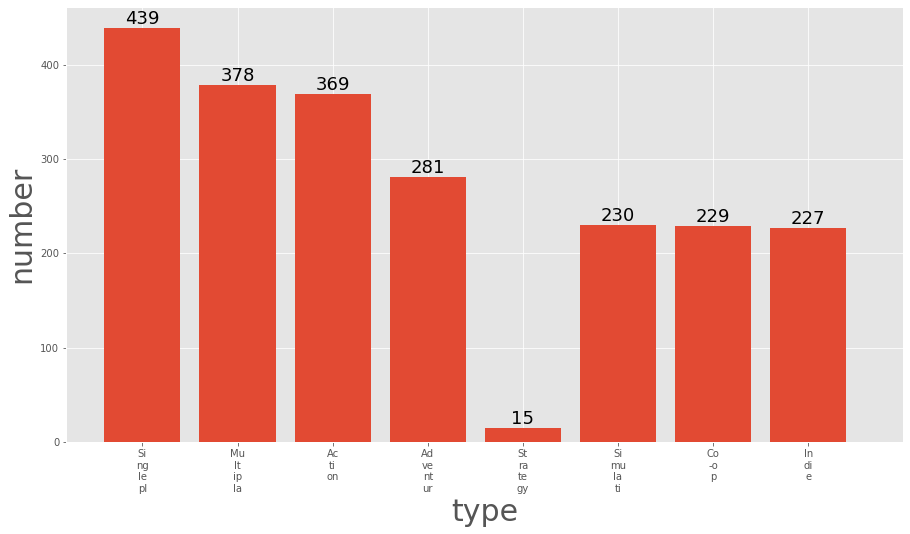

In [34]:
Y = list(frequency1.keys())[0:8]#取前10个标签
X = list(frequency1.values())[0:8]
plt.figure( figsize=(15, 8),)

plt.bar(Y,X)

plt.xlabel('type',fontsize=30)
plt.ylabel('number',fontsize=30)
plt.xlim(-.8, 8)
for a,b in zip(Y,X):
    plt.text(a, b,int(b), ha='center', va= 'bottom',fontsize=18)
plt.show()

### 2.3 好评率与销售额相关分析

In [12]:
#好评与销售额是否相关？ 叫好是否就卖座？
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from regressors import stats
#踢除免费游戏，探究付费游戏的销售额是否与好评率相关
data3 = data[data.价格 !=0] 
rate1 = data3['近期好评率']
rate =np.array(rate1).reshape(-1,1)
sales1 = data3['销售额']
sales = np.array(sales1).reshape(-1,1)
regr = linear_model.LinearRegression()
regr.fit(rate,sales)
sales_pred = regr.predict(rate)
print('R squared: %.9f' % r2_score(sales1, sales_pred))
#好评与销售额不线性相关

R squared: 0.000648557


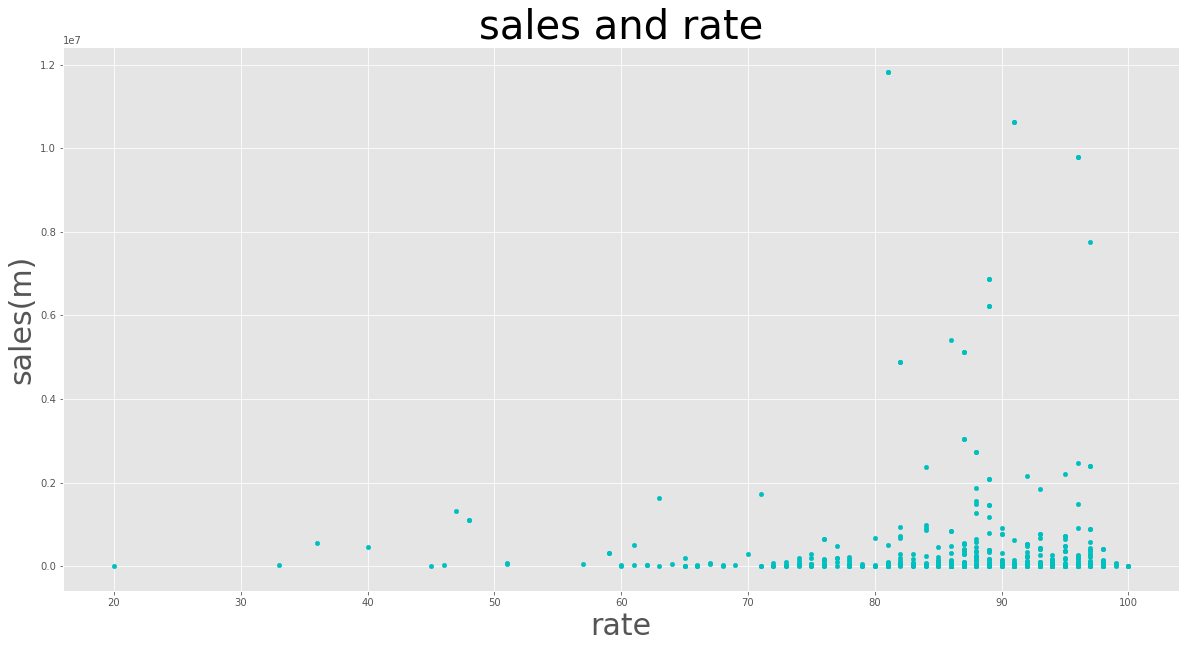

In [19]:
Y = data3['销售额'] 
X = data3['近期好评率']
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.scatter(X,Y,s=20,c='c')
plt.xlabel('rate',fontsize=30)
plt.ylabel('sales(m)',fontsize=30)
plt.title('sales and rate',fontsize=40)
plt.show()

## 3 地图分析（杨蕊嘉）

In [3]:
#pyecharts库中负责地理坐标系的模块是Geo，负责地图的模块是Map，负责百度地图的模块是BMap，负责图表配置的模块是options。在 pyecharts 中，图表的一切皆通过 options来修饰调整。
#导入包
# from example.commons import Faker
import pandas as pd
from pyecharts import options as opts 
from pyecharts.charts import Geo 
from pyecharts.globals import ChartType, SymbolType
from pyecharts.charts import Map

In [6]:
country = pd.read_excel('country.xlsx')
#map,国名必须为英文
c = (
        Map()
        .add("游戏公司销量Top20", [list(z) for z in zip(country.loc[:,'country'],country.loc[:,'sales'])],"world")
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        .set_global_opts(
            title_opts=opts.TitleOpts(title="Map-世界地图"),
            visualmap_opts=opts.VisualMapOpts(max_=67000000,min_=2100000),
        )
    )
c.render_notebook()

## 4 文本分析(李金隆、杨蕊嘉）

In [21]:
import numpy as np
from wordcloud import WordCloud,STOPWORDS
import jieba
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import plotly
import plotly.express as px
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###  4.1 Wordcloud

In [36]:
#设置屏蔽词（动词、程度词）
stopwords = set(STOPWORDS)
#stopwords.add('公司')stopwords.add('的')
# stopwords.add('公司')
stopwords = [line.strip() for line in open('停用词表.txt', encoding='UTF-8').readlines()]


#定义函数
def creat_wordcloud(picture ,name):
    image = Image.open(picture)#词云形状设置
    mask = np.array(image)
    # mask = np.array(Image.open("steam2.jpg"))
    filename = name
    with open(filename, 'rb') as f: #encoding = 'utf-8',改变为rb可以去读gkd编码
        mytext = f.read()
    mytext = ' '.join(jieba.cut(mytext))
    font ="STXINGKA.TTF"#字体设置
    word_cloud_4 = WordCloud(scale=4, #设置图片清晰度
                            background_color= 'white',#背景颜色
                             font_path=font, #字体设置
                             max_font_size=500,#词的数量
                             stopwords = stopwords,#屏蔽词
                             mask=mask).generate(mytext)
    plt.imshow(word_cloud_4, interpolation= 'bilinear')
    plt.axis('off') 
    plt.show()
    return word_cloud_4
#     word_cloud_4.to_file("output.png")#导出png格式的图片

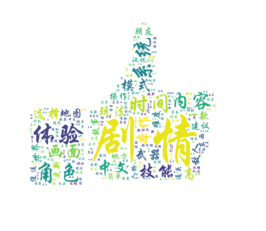

In [41]:
pds = pd.read_excel('pt_cm.xls')
pds.to_csv('positive.txt',header=None, sep = ' ', index = False)
word_cloud = creat_wordcloud('good.png', 'positive.txt')
# word_cloud.to_file('cm_po.png')

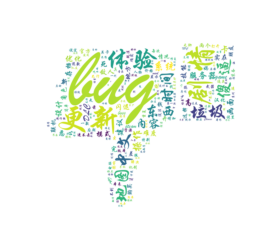

In [44]:
pds = pd.read_excel('ng_cm.xls')
pds.to_csv('neg.txt',header=None, sep = ' ', index = False)
word_cloud = creat_wordcloud('bad.png', 'neg.txt')
# word_cloud.to_file('cm_ng.png')

### 4.2 counts

In [28]:
def count_number(df_a):
    b = df_a.values.tolist()
    sss = ''.join([str(x) for x in b])
    words  = jieba.lcut(sss)  
    counts = {}  
    for word in words:  
        if word not in stopwords:
            if len(word) == 1:
                continue
            else:
                counts[word] = counts.get(word,0) + 1  
    items = list(counts.items())  
    items.sort(key=lambda x:x[1], reverse=True)  
    temp = pd.DataFrame(items[0:10],columns = ['name','number'])
    return temp

In [29]:
df_gdcm_sum = pd.read_excel('标签好评人数总和.xlsx')
df_gdcm_sum = df_gdcm_sum.loc[:,['tag','SUM']]
df_tag_cm = pd.read_excel('tag_cm.xlsx')
merged_cm = pd.merge(df_gdcm_sum,df_tag_cm)
merged_cm

,tag,SUM,0,1,2,3,4,5,6,7,...,445,446,447,448,449,450,451,452,453,454
0,Multiplayer,939192.18,真是个对新手十分友好的游戏，大家都很亲切，大家还都认识你妈妈，如果你打得好，他们还会对你的妈...,"我,是,傻,逼\n作为一个上班族，真想好好耐心下来玩命运2，但是真的没有固定的时间能找人一起...",操你妈，外挂多的要死，第一把就见到一个人在天上乱杀，反华废青还很多，几乎每把都有傻逼和死了妈...,游戏挺简单的，特别容易上手。游戏里面的朋友也非常友好，经常互相问候家人。特别推荐！\n11年...,"很好玩，但这个鬼老是搞偷袭，来偷袭我9岁的小同志，我劝这个鬼耗子尾汁，好好反思,\n今天就算...","We,need,ChineseWe,need,ChineseWe,need,ChineseW...",昨天有个朋友问我怎么了，发生肾膜事了，我一看，啊，原来是FM21出BETA了，我啪一下就点了...,"为什么要卖116，因为差你就是117了\n,, 欢迎关注,网易UU鉴赏家培养计划,,, 来这...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Co-op,816312.18,真是个对新手十分友好的游戏，大家都很亲切，大家还都认识你妈妈，如果你打得好，他们还会对你的妈...,"我,是,傻,逼\n作为一个上班族，真想好好耐心下来玩命运2，但是真的没有固定的时间能找人一起...",操你妈，外挂多的要死，第一把就见到一个人在天上乱杀，反华废青还很多，几乎每把都有傻逼和死了妈...,游戏挺简单的，特别容易上手。游戏里面的朋友也非常友好，经常互相问候家人。特别推荐！\n11年...,"很好玩，但这个鬼老是搞偷袭，来偷袭我9岁的小同志，我劝这个鬼耗子尾汁，好好反思,\n今天就算...","We,need,ChineseWe,need,ChineseWe,need,ChineseW...","为什么要卖116，因为差你就是117了\n,, 欢迎关注,网易UU鉴赏家培养计划,,, 来这...","希望快点把仁王2移植PC吧\n我是傻逼\n挺好玩的,很爽,很酷炫,当然,怪也这么觉得.\n铁...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Action,780912.95,真是个对新手十分友好的游戏，大家都很亲切，大家还都认识你妈妈，如果你打得好，他们还会对你的妈...,"我,是,傻,逼\n作为一个上班族，真想好好耐心下来玩命运2，但是真的没有固定的时间能找人一起...",操你妈，外挂多的要死，第一把就见到一个人在天上乱杀，反华废青还很多，几乎每把都有傻逼和死了妈...,游戏挺简单的，特别容易上手。游戏里面的朋友也非常友好，经常互相问候家人。特别推荐！\n11年...,"很好玩，但这个鬼老是搞偷袭，来偷袭我9岁的小同志，我劝这个鬼耗子尾汁，好好反思,\n今天就算...",NaN,第一350千万别买，要么转区，要么入主机版，傻逼公司把国区当猪宰，除此之外是好的，打击感连招...,"为什么要卖116，因为差你就是117了\n,, 欢迎关注,网易UU鉴赏家培养计划,,, 来这...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Online Co-Op,741399.91,真是个对新手十分友好的游戏，大家都很亲切，大家还都认识你妈妈，如果你打得好，他们还会对你的妈...,"我,是,傻,逼\n作为一个上班族，真想好好耐心下来玩命运2，但是真的没有固定的时间能找人一起...",操你妈，外挂多的要死，第一把就见到一个人在天上乱杀，反华废青还很多，几乎每把都有傻逼和死了妈...,游戏挺简单的，特别容易上手。游戏里面的朋友也非常友好，经常互相问候家人。特别推荐！\n11年...,"很好玩，但这个鬼老是搞偷袭，来偷袭我9岁的小同志，我劝这个鬼耗子尾汁，好好反思,\n今天就算...","We,need,ChineseWe,need,ChineseWe,need,ChineseW...","为什么要卖116，因为差你就是117了\n,, 欢迎关注,网易UU鉴赏家培养计划,,, 来这...",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,First-Person,567302.92,真是个对新手十分友好的游戏，大家都很亲切，大家还都认识你妈妈，如果你打得好，他们还会对你的妈...,"我,是,傻,逼\n作为一个上班族，真想好好耐心下来玩命运2，但是真的没有固定的时间能找人一起...",操你妈，外挂多的要死，第一把就见到一个人在天上乱杀，反华废青还很多，几乎每把都有傻逼和死了妈...,"很好玩，但这个鬼老是搞偷袭，来偷袭我9岁的小同志，我劝这个鬼耗子尾汁，好好反思,\n今天就算...",NaN,"为什么要卖116，因为差你就是117了\n,, 欢迎关注,网易UU鉴赏家培养计划,,, 来这...",0,这个游戏现在有一个很大的问题，那就是车队问题。在白天屠夫排不到，晚上人类排不到。于是乎晚上我...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,Utilities,39.00,NaN,除了没有中文什么都好。在没有填入key的状况下安装游戏是免费版的，请不要在免费版转正式版的更...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,Farming,28.00,第一350千万别买，要么转区，要么入主机版，傻逼公司把国区当猪宰，除此之外是好的，打击感连招...,"最大的缺陷就是土壤还是采用贴图模式,如果把土壤的物理效果做到真实一点,车辙和轮胎摩擦力随土壤...",第一350千万别买，要么转区，要么入主机版，傻逼公司把国区当猪宰，除此之外是好的，打击感连招...,"最大的缺陷就是土壤还是采用贴图模式,如果把土壤的物理效果做到真实一点,车辙和轮胎摩擦力随土壤...",需要创意工坊\n2017年刚出的时候买的，当时跟前任一起玩。两个人每天晚上挖矿，养动物、种地...,玩之前我以为，要靠完成心愿送各个角色成佛后来我发现，我能做到的，只有给他们一个尽量圆满的送别...,游戏好不好玩看个人胃口，这儿只提一下黑屏的问题：一点个人经验：1.先开steam，再点开始游...,"《Green,Project》是一款以探险为主的末日生存游戏，在这个荒凉并且被具有破坏性真菌...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,Auto Battler,27.84,5小时终于通关了一次，游戏难度偏大。目前来说感觉召唤流配合加召唤物伤害的巫师是比较好用的流派...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,Wrestling,20.46,"我是傻逼,\n厉害了,,,,原来8D会影分身。和他打到一半另外一个8D冲出来兑包,,,强行变...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
names = locals()
i = 0
for i in range(0,100,10):
    names['x' + str(i)] = count_number(merged_cm.loc[i])
    names['x' + str(i)]['tag'] = merged_cm.loc[i,'tag']
merged_all = pd.concat([x0,x10,x20,x30,x40,x50,x60,x70,x80,x90])
merged_all

,name,number,tag
0,中文,868,Multiplayer
1,体验,698,Multiplayer
2,模式,653,Multiplayer
3,剧情,616,Multiplayer
4,时间,553,Multiplayer
...,...,...,...
5,种田,89,Loot
6,攻击,76,Loot
7,剧情,72,Loot
8,时间,69,Loot


In [32]:
fig = px.treemap(merged_all, path = ['tag','name'], values="number")
fig.show()
plotly.offline.plot(fig,filename = 'tag_count_words.html')

'tag_count_words.html'